In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.7 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit
import optuna

# Set random seeds
np.random.seed(2023)
tf.random.set_seed(2023)

# Check if GPU is available for use
print(tf.config.list_physical_devices('GPU'))

if len(tf.config.list_physical_devices('GPU')) > 0:
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

[]


device(type='cpu')

Functions

In [3]:
def get_feature_arr(df, window_size):
    # generate np array for input features for LSTM
    values = df.values

    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(values)

    x = []
    for i in range(window_size, len(data)):
            x.append(data[i-window_size:i, :])
    x = np.array(x)

    return x

def get_label_arr(df, window_size):
    # generate np array for for output labels for LSTM

    # change value to size 3 array
    label_arr = to_categorical(df.values, num_classes=2)
    y = []
    for i in range(window_size, len(label_arr)):
        y.append(label_arr[i])
    y = np.array(y)
    return y

def onehot2labels(arr):
    # get label from size 3 arr (similar to softmax)
    arr1 = []
    for i in range(len(arr)):
        arr1.append(np.argmax(arr[i]))
    return np.array(arr1)

def calc_accuracy(preds, results):
    # calculate prediction accuracy
    preds = onehot2labels(preds)
    results = onehot2labels(results)
    
    return accuracy_score(results, preds)

# Define number of folds for cross-validation
num_folds = 5

# Define time series split object
tscv = TimeSeriesSplit(n_splits=num_folds)

def cross_fold_acc(data, labels, model, early_stop):
    # 5-fold cross-validation 
    acc_arr = []

    # Loop over folds and perform cross-validation
    for fold, (train_index, test_index) in enumerate(tscv.split(data)):

        # Extract train and test data for this fold
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        

        one_acc = 0
        for i in y_test:
            if np.argmax(i) == 1:
                one_acc += 1
        one_acc /= len(y_test)
        
        # Train and evaluate the model on this fold
        model.fit(X_train, y_train, epochs=40, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)
        y_pred = model.predict(X_test)

        print(f'lstm: {calc_accuracy(y_test, y_pred)}, one_acc: {one_acc}')

        acc_arr.append(calc_accuracy(y_test, y_pred) - one_acc)
    
    return np.mean(acc_arr)


def training_acc(data, labels, model, early_stop):
    X_train, X_test = data[:-107], data[-107:]
    y_train, y_test = labels[:-107], labels[-107:]

    print(X_train.shape, X_test.shape)

    zero_acc = 0
    for i in y_test:
        if np.argmax(i) == 0:
            zero_acc = zero_acc + 1
    zero_acc /= len(y_test)

    model.fit(X_train, y_train, epochs=60, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)
    y_pred = model.predict(X_test)

    print(f'lstm: {calc_accuracy(y_test, y_pred)}, one_acc: {zero_acc}')

    return calc_accuracy(y_test, y_pred)


# Define the function that creates and trains the LSTM model with given hyperparameters
def create_lstm_model(trial):
    # Define the hyperparameters to tune
    # num of nodes in lstm layer
    lstm_units = trial.suggest_int('lstm_units', 10, 200)
    # num of nodes in dense layer
    n_units = trial.suggest_int('n_units', 10, 200)
    # learning rate
    lr_rate = trial.suggest_float('lr_rate', 1E-3, 1E-1)
    

    model = keras.Sequential()
    model.add(layers.LSTM(lstm_units, return_sequences=True, input_shape=(window_size, num_features)))
    model.add(layers.LSTM(lstm_units, return_sequences=False))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(n_units))
    model.add(layers.Dense(2, activation='softmax'))

    # Compile the model with the given learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    # Train the model with early stopping
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    acc1 = cross_fold_acc(feature_arr, label_arr, model, early_stop)
    return acc1

# Define the Optuna objective function to minimize
def objective(trial):
    loss = create_lstm_model(trial)
    return loss

Settings

In [4]:
stock_list = ['GME', 'AMC', 'BBBY','TSLA', 'AAPL', 'MSFT', 'SPY']
window_size = 30

feature_list = ['open', 'high', 'low', 'close', 'adjclose', 'volume',
       'returns1', 'volatility5', 'rsi5',
       'rsi5label', 'ma5', 'volatility10', 'rsi10',
       'rsi10label', 'ma10', 'volatility15', 'rsi15',
       'rsi15label', 'ma15', 'volatility30', 'rsi30',
       'rsi30label', 'ma30', 'bb_signals', 'labels']
num_features = len(feature_list)


# Define number of folds for cross-validation
num_folds = 5

# Define time series split object
tscv = TimeSeriesSplit(n_splits=num_folds)

# Train the model with early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

stock_df_list = []
for s in stock_list:
    full_data = pd.read_csv(s + '.csv')
    stock_df_list.append(full_data)

GME


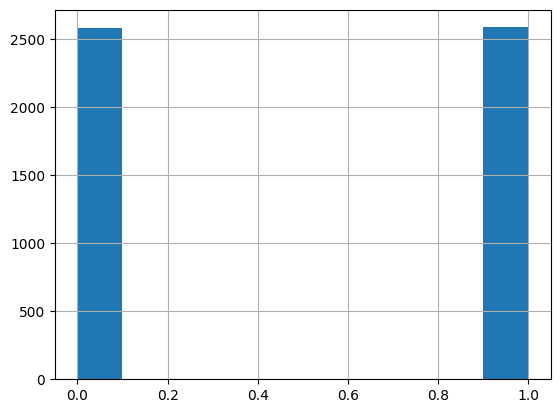

[I 2023-04-23 14:06:52,886] A new study created in memory with name: no-name-474dc6a3-d3f4-4e52-b63f-4edcea5bcf09


27/27 [==============================] - 3s 7ms/step
lstm: 0.49883177570093457, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5011682242990654, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 3ms/step
lstm: 0.5023364485981309, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 3ms/step


[I 2023-04-23 14:07:41,389] Trial 0 finished with value: 0.010747663551401877 and parameters: {'lstm_units': 102, 'n_units': 85, 'lr_rate': 0.08102921666478842}. Best is trial 0 with value: 0.010747663551401877.


lstm: 0.5280373831775701, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 3ms/step
lstm: 0.5280373831775701, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 4ms/step
lstm: 0.4976635514018692, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 3ms/step
lstm: 0.5023364485981309, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 3ms/step


[I 2023-04-23 14:08:20,193] Trial 1 finished with value: 0.015887850467289744 and parameters: {'lstm_units': 31, 'n_units': 173, 'lr_rate': 0.015867121207618236}. Best is trial 1 with value: 0.015887850467289744.


lstm: 0.5280373831775701, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 3ms/step
lstm: 0.5210280373831776, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.514018691588785, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 5ms/step
lstm: 0.514018691588785, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 3ms/step
lstm: 0.5186915887850467, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 6ms/step


[I 2023-04-23 14:08:52,830] Trial 2 finished with value: 0.013785046728971961 and parameters: {'lstm_units': 92, 'n_units': 184, 'lr_rate': 0.004306463659575261}. Best is trial 1 with value: 0.015887850467289744.


lstm: 0.5116822429906542, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 3ms/step
lstm: 0.508177570093458, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 4ms/step
lstm: 0.508177570093458, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 3ms/step
lstm: 0.5023364485981309, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 4ms/step


[I 2023-04-23 14:09:19,972] Trial 3 finished with value: 0.014018691588785081 and parameters: {'lstm_units': 60, 'n_units': 181, 'lr_rate': 0.041898525917968485}. Best is trial 1 with value: 0.015887850467289744.


lstm: 0.5280373831775701, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 3ms/step
lstm: 0.5011682242990654, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.49883177570093457, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 4ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 3ms/step
lstm: 0.5023364485981309, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 5ms/step


[I 2023-04-23 14:09:59,338] Trial 4 finished with value: 0.010747663551401877 and parameters: {'lstm_units': 89, 'n_units': 162, 'lr_rate': 0.06427904259053287}. Best is trial 1 with value: 0.015887850467289744.


lstm: 0.5280373831775701, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 3ms/step
lstm: 0.5549065420560748, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.49883177570093457, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 3ms/step
lstm: 0.5023364485981309, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 3ms/step


[I 2023-04-23 14:10:29,873] Trial 5 finished with value: 0.021495327102803764 and parameters: {'lstm_units': 93, 'n_units': 72, 'lr_rate': 0.0192346399735825}. Best is trial 5 with value: 0.021495327102803764.


lstm: 0.5280373831775701, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 3ms/step
lstm: 0.5350467289719626, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5128504672897196, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 4ms/step
lstm: 0.5280373831775701, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 4ms/step
lstm: 0.5175233644859814, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 3ms/step


[I 2023-04-23 14:11:06,235] Trial 6 finished with value: 0.020093457943925253 and parameters: {'lstm_units': 134, 'n_units': 193, 'lr_rate': 0.0013981187492474647}. Best is trial 5 with value: 0.021495327102803764.


lstm: 0.5175233644859814, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 3ms/step
lstm: 0.5011682242990654, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5011682242990654, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 4ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 3ms/step
lstm: 0.5023364485981309, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 5ms/step


[I 2023-04-23 14:11:40,424] Trial 7 finished with value: 0.011214953271028038 and parameters: {'lstm_units': 75, 'n_units': 101, 'lr_rate': 0.09204077265678105}. Best is trial 5 with value: 0.021495327102803764.


lstm: 0.5280373831775701, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 3ms/step
lstm: 0.5023364485981309, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 4ms/step
lstm: 0.5, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 4ms/step
lstm: 0.5023364485981309, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 4ms/step


[I 2023-04-23 14:12:08,227] Trial 8 finished with value: 0.005373831775700955 and parameters: {'lstm_units': 140, 'n_units': 23, 'lr_rate': 0.03809510287767959}. Best is trial 5 with value: 0.021495327102803764.


lstm: 0.49883177570093457, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 3ms/step
lstm: 0.49883177570093457, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 4ms/step
lstm: 0.49883177570093457, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 3ms/step
lstm: 0.5023364485981309, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 3ms/step


[I 2023-04-23 14:12:49,191] Trial 9 finished with value: 0.010280373831775713 and parameters: {'lstm_units': 83, 'n_units': 181, 'lr_rate': 0.06906011267934434}. Best is trial 5 with value: 0.021495327102803764.


lstm: 0.5280373831775701, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 4ms/step
lstm: 0.5011682242990654, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 4ms/step
lstm: 0.5023364485981309, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 4ms/step
lstm: 0.4894859813084112, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 5ms/step


[I 2023-04-23 14:13:34,913] Trial 10 finished with value: 0.008878504672897202 and parameters: {'lstm_units': 173, 'n_units': 48, 'lr_rate': 0.027444580661327118}. Best is trial 5 with value: 0.021495327102803764.


lstm: 0.5280373831775701, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 4ms/step
lstm: 0.5327102803738317, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.514018691588785, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 4ms/step
lstm: 0.46845794392523366, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 4ms/step
lstm: 0.522196261682243, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 3ms/step


[I 2023-04-23 14:14:16,949] Trial 11 finished with value: 0.001635514018691575 and parameters: {'lstm_units': 139, 'n_units': 138, 'lr_rate': 0.001668214033053441}. Best is trial 5 with value: 0.021495327102803764.


lstm: 0.48130841121495327, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 3ms/step
lstm: 0.49883177570093457, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5046728971962616, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 4ms/step
lstm: 0.4661214953271028, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 3ms/step
lstm: 0.5023364485981309, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 3ms/step


[I 2023-04-23 14:15:00,169] Trial 12 finished with value: -0.0018691588785046843 and parameters: {'lstm_units': 133, 'n_units': 70, 'lr_rate': 0.021381080600143782}. Best is trial 5 with value: 0.021495327102803764.


lstm: 0.5292056074766355, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 4ms/step
lstm: 0.5455607476635514, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.49649532710280375, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 5ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 5ms/step
lstm: 0.514018691588785, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 4ms/step


[I 2023-04-23 14:15:34,111] Trial 13 finished with value: 0.02032710280373833 and parameters: {'lstm_units': 193, 'n_units': 132, 'lr_rate': 0.012872203822896146}. Best is trial 5 with value: 0.021495327102803764.


lstm: 0.522196261682243, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 4ms/step
lstm: 0.49883177570093457, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5011682242990654, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 5ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 4ms/step
lstm: 0.5023364485981309, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 3ms/step


[I 2023-04-23 14:16:16,928] Trial 14 finished with value: 0.010747663551401877 and parameters: {'lstm_units': 195, 'n_units': 128, 'lr_rate': 0.031838228473867025}. Best is trial 5 with value: 0.021495327102803764.


lstm: 0.5280373831775701, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 3ms/step
lstm: 0.5011682242990654, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.49649532710280375, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 3ms/step
lstm: 0.49182242990654207, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 3ms/step


[I 2023-04-23 14:16:48,577] Trial 15 finished with value: 0.008177570093457954 and parameters: {'lstm_units': 23, 'n_units': 123, 'lr_rate': 0.01845639815208676}. Best is trial 5 with value: 0.021495327102803764.


lstm: 0.5280373831775701, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 4ms/step
lstm: 0.5011682242990654, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 5ms/step
lstm: 0.5011682242990654, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 4ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 3ms/step
lstm: 0.5023364485981309, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 3ms/step


[I 2023-04-23 14:17:33,383] Trial 16 finished with value: 0.011214953271028038 and parameters: {'lstm_units': 171, 'n_units': 60, 'lr_rate': 0.04282390810339194}. Best is trial 5 with value: 0.021495327102803764.


lstm: 0.5280373831775701, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 3ms/step
lstm: 0.5490654205607477, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 4ms/step
lstm: 0.4941588785046729, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 3ms/step
lstm: 0.5023364485981309, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 4ms/step


[I 2023-04-23 14:18:10,567] Trial 17 finished with value: 0.019392523364486002 and parameters: {'lstm_units': 54, 'n_units': 10, 'lr_rate': 0.052233292576039675}. Best is trial 5 with value: 0.021495327102803764.


lstm: 0.5280373831775701, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 3ms/step
lstm: 0.5373831775700935, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5035046728971962, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 4ms/step
lstm: 0.5023364485981309, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 4ms/step


[I 2023-04-23 14:18:48,783] Trial 18 finished with value: 0.01892523364485983 and parameters: {'lstm_units': 115, 'n_units': 101, 'lr_rate': 0.01371745488917253}. Best is trial 5 with value: 0.021495327102803764.


lstm: 0.5280373831775701, one_acc: 0.4719626168224299
27/27 [==============================] - 1s 4ms/step
lstm: 0.5233644859813084, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 4ms/step
lstm: 0.4941588785046729, one_acc: 0.5011682242990654
27/27 [==============================] - 0s 3ms/step
lstm: 0.5338785046728972, one_acc: 0.5338785046728972
27/27 [==============================] - 0s 3ms/step
lstm: 0.5023364485981309, one_acc: 0.5023364485981309
27/27 [==============================] - 0s 3ms/step


[I 2023-04-23 14:19:31,886] Trial 19 finished with value: 0.014252336448598135 and parameters: {'lstm_units': 197, 'n_units': 46, 'lr_rate': 0.02771076530832969}. Best is trial 5 with value: 0.021495327102803764.


lstm: 0.5280373831775701, one_acc: 0.4719626168224299
Best parameters: {'lstm_units': 93, 'n_units': 72, 'lr_rate': 0.0192346399735825}
AMC


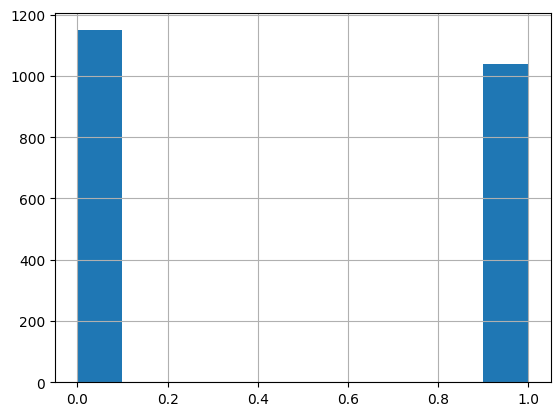

[I 2023-04-23 14:19:32,084] A new study created in memory with name: no-name-c7e41e37-687c-427e-ae8a-652fd8fdb460


12/12 [==============================] - 1s 3ms/step
lstm: 0.5125348189415042, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 3ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 3ms/step
lstm: 0.5069637883008357, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 4ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 3ms/step


[I 2023-04-23 14:19:49,165] Trial 0 finished with value: 0.0818941504178273 and parameters: {'lstm_units': 10, 'n_units': 61, 'lr_rate': 0.026628493436719657}. Best is trial 0 with value: 0.0818941504178273.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 4ms/step
lstm: 0.5236768802228412, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 4ms/step
lstm: 0.5487465181058496, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 3ms/step
lstm: 0.5598885793871866, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 3ms/step
lstm: 0.5682451253481894, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 3ms/step


[I 2023-04-23 14:20:09,764] Trial 1 finished with value: 0.09136490250696377 and parameters: {'lstm_units': 176, 'n_units': 112, 'lr_rate': 0.012681293745938588}. Best is trial 1 with value: 0.09136490250696377.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 4ms/step
lstm: 0.5125348189415042, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 4ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 4ms/step
lstm: 0.5069637883008357, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 5ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 4ms/step


[I 2023-04-23 14:20:32,541] Trial 2 finished with value: 0.0818941504178273 and parameters: {'lstm_units': 137, 'n_units': 121, 'lr_rate': 0.01412929649754337}. Best is trial 1 with value: 0.09136490250696377.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 4ms/step
lstm: 0.48746518105849584, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 3ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 3ms/step
lstm: 0.5069637883008357, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 4ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 4ms/step


[I 2023-04-23 14:20:54,392] Trial 3 finished with value: 0.07688022284122562 and parameters: {'lstm_units': 163, 'n_units': 47, 'lr_rate': 0.09147487171352657}. Best is trial 1 with value: 0.09136490250696377.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 5ms/step
lstm: 0.4958217270194986, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 3ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 4ms/step
lstm: 0.532033426183844, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 3ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 5ms/step


[I 2023-04-23 14:21:16,518] Trial 4 finished with value: 0.08356545961002784 and parameters: {'lstm_units': 11, 'n_units': 146, 'lr_rate': 0.04072712759870471}. Best is trial 1 with value: 0.09136490250696377.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 4ms/step
lstm: 0.5236768802228412, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 3ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 5ms/step
lstm: 0.5153203342618384, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 3ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 4ms/step


[I 2023-04-23 14:21:39,011] Trial 5 finished with value: 0.08579387186629525 and parameters: {'lstm_units': 177, 'n_units': 194, 'lr_rate': 0.011292726986563834}. Best is trial 1 with value: 0.09136490250696377.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 4ms/step
lstm: 0.5125348189415042, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 4ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 5ms/step
lstm: 0.5069637883008357, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 4ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 3ms/step


[I 2023-04-23 14:22:01,173] Trial 6 finished with value: 0.0818941504178273 and parameters: {'lstm_units': 140, 'n_units': 117, 'lr_rate': 0.021437648894510195}. Best is trial 1 with value: 0.09136490250696377.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 4ms/step
lstm: 0.5125348189415042, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 3ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 3ms/step
lstm: 0.5069637883008357, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 4ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 4ms/step


[I 2023-04-23 14:22:20,234] Trial 7 finished with value: 0.0818941504178273 and parameters: {'lstm_units': 73, 'n_units': 36, 'lr_rate': 0.06388574026186301}. Best is trial 1 with value: 0.09136490250696377.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 3ms/step
lstm: 0.5125348189415042, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 4ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 3ms/step
lstm: 0.5069637883008357, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 3ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 3ms/step


[I 2023-04-23 14:22:45,837] Trial 8 finished with value: 0.0818941504178273 and parameters: {'lstm_units': 122, 'n_units': 145, 'lr_rate': 0.07395487650536357}. Best is trial 1 with value: 0.09136490250696377.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 4ms/step
lstm: 0.5125348189415042, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 4ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 5ms/step
lstm: 0.5069637883008357, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 3ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 3ms/step


[I 2023-04-23 14:23:07,414] Trial 9 finished with value: 0.0818941504178273 and parameters: {'lstm_units': 119, 'n_units': 95, 'lr_rate': 0.018053046947687248}. Best is trial 1 with value: 0.09136490250696377.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 5ms/step
lstm: 0.5125348189415042, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 3ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 3ms/step
lstm: 0.5069637883008357, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 4ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 3ms/step


[I 2023-04-23 14:23:30,596] Trial 10 finished with value: 0.0818941504178273 and parameters: {'lstm_units': 198, 'n_units': 190, 'lr_rate': 0.040834806028030406}. Best is trial 1 with value: 0.09136490250696377.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 6ms/step
lstm: 0.5041782729805014, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 3ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 3ms/step
lstm: 0.5376044568245125, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 4ms/step
lstm: 0.5766016713091922, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 4ms/step


[I 2023-04-23 14:23:55,582] Trial 11 finished with value: 0.08857938718662951 and parameters: {'lstm_units': 200, 'n_units': 199, 'lr_rate': 0.004321193775642442}. Best is trial 1 with value: 0.09136490250696377.


lstm: 0.5598885793871866, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 3ms/step
lstm: 0.5236768802228412, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 4ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 3ms/step
lstm: 0.5515320334261838, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 3ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 3ms/step


[I 2023-04-23 14:24:14,349] Trial 12 finished with value: 0.09303621169916433 and parameters: {'lstm_units': 197, 'n_units': 167, 'lr_rate': 0.0023706555261508513}. Best is trial 12 with value: 0.09303621169916433.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 4ms/step
lstm: 0.5097493036211699, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 4ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 3ms/step
lstm: 0.5459610027855153, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 3ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 3ms/step


[I 2023-04-23 14:24:30,899] Trial 13 finished with value: 0.08913649025069635 and parameters: {'lstm_units': 84, 'n_units': 158, 'lr_rate': 0.0015632744727808994}. Best is trial 12 with value: 0.09303621169916433.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 4ms/step
lstm: 0.5125348189415042, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 5ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 3ms/step
lstm: 0.5069637883008357, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 3ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 3ms/step


[I 2023-04-23 14:24:55,619] Trial 14 finished with value: 0.0818941504178273 and parameters: {'lstm_units': 165, 'n_units': 88, 'lr_rate': 0.03074674345207811}. Best is trial 12 with value: 0.09303621169916433.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 4ms/step
lstm: 0.5125348189415042, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 3ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 4ms/step
lstm: 0.520891364902507, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 3ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 4ms/step


[I 2023-04-23 14:25:19,015] Trial 15 finished with value: 0.08467966573816156 and parameters: {'lstm_units': 177, 'n_units': 68, 'lr_rate': 0.0019619193108987784}. Best is trial 12 with value: 0.09303621169916433.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 3ms/step
lstm: 0.5125348189415042, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 4ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 4ms/step
lstm: 0.5069637883008357, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 3ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 4ms/step


[I 2023-04-23 14:25:41,157] Trial 16 finished with value: 0.0818941504178273 and parameters: {'lstm_units': 47, 'n_units': 167, 'lr_rate': 0.03386609180391234}. Best is trial 12 with value: 0.09303621169916433.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 6ms/step
lstm: 0.5125348189415042, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 3ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 3ms/step
lstm: 0.5069637883008357, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 5ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 4ms/step


[I 2023-04-23 14:26:03,540] Trial 17 finished with value: 0.0818941504178273 and parameters: {'lstm_units': 154, 'n_units': 16, 'lr_rate': 0.014388082254792807}. Best is trial 12 with value: 0.09303621169916433.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 4ms/step
lstm: 0.48746518105849584, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 3ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 6ms/step
lstm: 0.5069637883008357, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 3ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 3ms/step


[I 2023-04-23 14:26:24,616] Trial 18 finished with value: 0.07688022284122562 and parameters: {'lstm_units': 184, 'n_units': 128, 'lr_rate': 0.04925690541525568}. Best is trial 12 with value: 0.09303621169916433.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
12/12 [==============================] - 1s 4ms/step
lstm: 0.5125348189415042, one_acc: 0.48746518105849584
12/12 [==============================] - 0s 3ms/step
lstm: 0.5598885793871866, one_acc: 0.4401114206128134
12/12 [==============================] - 0s 4ms/step
lstm: 0.5041782729805014, one_acc: 0.49303621169916434
12/12 [==============================] - 0s 3ms/step
lstm: 0.5738161559888579, one_acc: 0.42618384401114207
12/12 [==============================] - 0s 4ms/step


[I 2023-04-23 14:26:45,508] Trial 19 finished with value: 0.08133704735376045 and parameters: {'lstm_units': 103, 'n_units': 173, 'lr_rate': 0.022840949263689427}. Best is trial 12 with value: 0.09303621169916433.


lstm: 0.5515320334261838, one_acc: 0.44846796657381616
Best parameters: {'lstm_units': 197, 'n_units': 167, 'lr_rate': 0.0023706555261508513}
BBBY


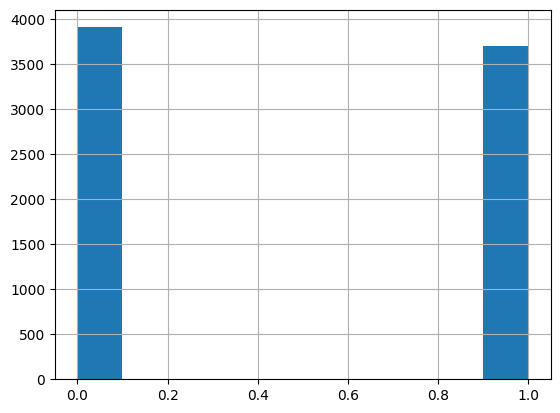

[I 2023-04-23 14:26:45,766] A new study created in memory with name: no-name-b73ac91b-67e8-4a3a-a214-2aeabda1a0df


40/40 [==============================] - 1s 4ms/step
lstm: 0.498812351543943, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 4ms/step
lstm: 0.5241488519398259, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 4ms/step
lstm: 0.5146476642913698, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 4ms/step
lstm: 0.49643705463182897, one_acc: 0.4758511480601742


[I 2023-04-23 14:27:25,390] Trial 0 finished with value: 0.017577197149643696 and parameters: {'lstm_units': 27, 'n_units': 141, 'lr_rate': 0.019363407557175347}. Best is trial 0 with value: 0.017577197149643696.


40/40 [==============================] - 1s 5ms/step
lstm: 0.5067300079176563, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 3ms/step
lstm: 0.5043547110055424, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 4ms/step
lstm: 0.5241488519398259, one_acc: 0.4758511480601742

[I 2023-04-23 14:28:01,662] Trial 1 finished with value: 0.02026920031670625 and parameters: {'lstm_units': 135, 'n_units': 94, 'lr_rate': 0.09127384312184254}. Best is trial 1 with value: 0.02026920031670625.



40/40 [==============================] - 1s 5ms/step
lstm: 0.5019794140934284, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 3ms/step
lstm: 0.5114806017418844, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 3ms/step
lstm: 0.5043547110055424, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 3ms/step
lstm: 0.5241488519398259, one_acc: 0.4758511480601742


[I 2023-04-23 14:28:36,209] Trial 2 finished with value: 0.019160728424386386 and parameters: {'lstm_units': 78, 'n_units': 108, 'lr_rate': 0.044108573352906015}. Best is trial 1 with value: 0.02026920031670625.


40/40 [==============================] - 1s 3ms/step
lstm: 0.49802058590657167, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 5ms/step
lstm: 0.5114806017418844, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 3ms/step
lstm: 0.5043547110055424, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 5ms/step
lstm: 0.5241488519398259, one_acc: 0.4758511480601742


[I 2023-04-23 14:29:18,005] Trial 3 finished with value: 0.018368962787015043 and parameters: {'lstm_units': 142, 'n_units': 31, 'lr_rate': 0.08009860018011968}. Best is trial 1 with value: 0.02026920031670625.


40/40 [==============================] - 1s 4ms/step
lstm: 0.49802058590657167, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 3ms/step
lstm: 0.5098970704671417, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 3ms/step
lstm: 0.5312747426761678, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 4ms/step
lstm: 0.5193982581155978, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 4ms/step
lstm: 0.5241488519398259, one_acc: 0.4758511480601742


[I 2023-04-23 14:30:17,137] Trial 4 finished with value: 0.024861441013460005 and parameters: {'lstm_units': 151, 'n_units': 11, 'lr_rate': 0.014980321414993447}. Best is trial 4 with value: 0.024861441013460005.


40/40 [==============================] - 1s 3ms/step
lstm: 0.49802058590657167, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 5ms/step
lstm: 0.5114806017418844, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 3ms/step
lstm: 0.5043547110055424, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 4ms/step


[I 2023-04-23 14:30:59,527] Trial 5 finished with value: 0.018368962787015043 and parameters: {'lstm_units': 91, 'n_units': 28, 'lr_rate': 0.08461099420920351}. Best is trial 4 with value: 0.024861441013460005.


lstm: 0.5241488519398259, one_acc: 0.4758511480601742
40/40 [==============================] - 1s 3ms/step
lstm: 0.501187648456057, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 5ms/step
lstm: 0.5114806017418844, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 3ms/step
lstm: 0.5043547110055424, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 3ms/step


[I 2023-04-23 14:31:44,164] Trial 6 finished with value: 0.01900237529691211 and parameters: {'lstm_units': 15, 'n_units': 104, 'lr_rate': 0.0791219140304449}. Best is trial 4 with value: 0.024861441013460005.


lstm: 0.5241488519398259, one_acc: 0.4758511480601742
40/40 [==============================] - 1s 4ms/step
lstm: 0.5019794140934284, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 4ms/step
lstm: 0.5114806017418844, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 4ms/step
lstm: 0.49564528899445764, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 3ms/step


[I 2023-04-23 14:32:35,735] Trial 7 finished with value: 0.017418844022169432 and parameters: {'lstm_units': 196, 'n_units': 90, 'lr_rate': 0.07074949087859717}. Best is trial 4 with value: 0.024861441013460005.


lstm: 0.5241488519398259, one_acc: 0.4758511480601742
40/40 [==============================] - 1s 3ms/step
lstm: 0.5193982581155978, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 3ms/step
lstm: 0.5106888361045131, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 4ms/step
lstm: 0.5043547110055424, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 4ms/step


[I 2023-04-23 14:33:32,409] Trial 8 finished with value: 0.022486144101346018 and parameters: {'lstm_units': 190, 'n_units': 178, 'lr_rate': 0.05909279875351254}. Best is trial 4 with value: 0.024861441013460005.


lstm: 0.5241488519398259, one_acc: 0.4758511480601742
40/40 [==============================] - 1s 3ms/step
lstm: 0.5019794140934284, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 4ms/step
lstm: 0.5114806017418844, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 3ms/step
lstm: 0.5019794140934284, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 4ms/step


[I 2023-04-23 14:34:11,075] Trial 9 finished with value: 0.01868566904196358 and parameters: {'lstm_units': 51, 'n_units': 163, 'lr_rate': 0.0734218621368912}. Best is trial 4 with value: 0.024861441013460005.


lstm: 0.5241488519398259, one_acc: 0.4758511480601742
40/40 [==============================] - 1s 3ms/step
lstm: 0.49802058590657167, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 3ms/step
lstm: 0.5257323832145685, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 3ms/step
lstm: 0.505938242280285, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 3ms/step
lstm: 0.5075217735550277, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 5ms/step


[I 2023-04-23 14:34:48,813] Trial 10 finished with value: 0.01931908155186063 and parameters: {'lstm_units': 143, 'n_units': 54, 'lr_rate': 0.00243583316153146}. Best is trial 4 with value: 0.024861441013460005.


lstm: 0.517814726840855, one_acc: 0.4758511480601742
40/40 [==============================] - 1s 4ms/step
lstm: 0.5019794140934284, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 5ms/step
lstm: 0.5114806017418844, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 4ms/step
lstm: 0.49564528899445764, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 3ms/step


[I 2023-04-23 14:35:46,193] Trial 11 finished with value: 0.017418844022169432 and parameters: {'lstm_units': 194, 'n_units': 196, 'lr_rate': 0.046961903059753396}. Best is trial 4 with value: 0.024861441013460005.


lstm: 0.5241488519398259, one_acc: 0.4758511480601742
40/40 [==============================] - 1s 4ms/step
lstm: 0.498812351543943, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 5ms/step
lstm: 0.5106888361045131, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 4ms/step
lstm: 0.5043547110055424, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 4ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 4ms/step


[I 2023-04-23 14:36:45,964] Trial 12 finished with value: 0.018368962787015053 and parameters: {'lstm_units': 168, 'n_units': 197, 'lr_rate': 0.03088298708095002}. Best is trial 4 with value: 0.024861441013460005.


lstm: 0.5241488519398259, one_acc: 0.4758511480601742
40/40 [==============================] - 1s 4ms/step
lstm: 0.49802058590657167, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 4ms/step
lstm: 0.5114806017418844, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 3ms/step
lstm: 0.49564528899445764, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 4ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 3ms/step


[I 2023-04-23 14:37:29,534] Trial 13 finished with value: 0.01662707838479809 and parameters: {'lstm_units': 167, 'n_units': 147, 'lr_rate': 0.058296757252789634}. Best is trial 4 with value: 0.024861441013460005.


lstm: 0.5241488519398259, one_acc: 0.4758511480601742
40/40 [==============================] - 1s 3ms/step
lstm: 0.48693586698337293, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 3ms/step
lstm: 0.5114806017418844, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 3ms/step
lstm: 0.49564528899445764, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 4ms/step


[I 2023-04-23 14:38:01,365] Trial 14 finished with value: 0.014410134600158341 and parameters: {'lstm_units': 118, 'n_units': 62, 'lr_rate': 0.05867108841438827}. Best is trial 4 with value: 0.024861441013460005.


lstm: 0.5241488519398259, one_acc: 0.4758511480601742
40/40 [==============================] - 1s 3ms/step
lstm: 0.49802058590657167, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 3ms/step
lstm: 0.5114806017418844, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 5ms/step
lstm: 0.5043547110055424, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 3ms/step


[I 2023-04-23 14:38:43,097] Trial 15 finished with value: 0.018368962787015043 and parameters: {'lstm_units': 164, 'n_units': 14, 'lr_rate': 0.0346357740909615}. Best is trial 4 with value: 0.024861441013460005.


lstm: 0.5241488519398259, one_acc: 0.4758511480601742
40/40 [==============================] - 1s 4ms/step
lstm: 0.5225653206650831, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 4ms/step
lstm: 0.5217735550277118, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 4ms/step
lstm: 0.501187648456057, one_acc: 0.4758511480601742


[I 2023-04-23 14:39:24,276] Trial 16 finished with value: 0.02232779097387172 and parameters: {'lstm_units': 178, 'n_units': 170, 'lr_rate': 0.004520888126317395}. Best is trial 4 with value: 0.024861441013460005.


40/40 [==============================] - 1s 3ms/step
lstm: 0.5027711797307997, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 3ms/step
lstm: 0.5114806017418844, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 3ms/step
lstm: 0.5043547110055424, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 3ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 4ms/step


[I 2023-04-23 14:40:09,838] Trial 17 finished with value: 0.01931908155186064 and parameters: {'lstm_units': 125, 'n_units': 128, 'lr_rate': 0.09642885373919718}. Best is trial 4 with value: 0.024861441013460005.


lstm: 0.5241488519398259, one_acc: 0.4758511480601742
40/40 [==============================] - 1s 3ms/step
lstm: 0.49802058590657167, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 3ms/step
lstm: 0.5225653206650831, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 3ms/step
lstm: 0.5130641330166271, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 4ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 3ms/step


[I 2023-04-23 14:40:40,274] Trial 18 finished with value: 0.02232779097387173 and parameters: {'lstm_units': 102, 'n_units': 59, 'lr_rate': 0.014872226791289564}. Best is trial 4 with value: 0.024861441013460005.


lstm: 0.5241488519398259, one_acc: 0.4758511480601742
40/40 [==============================] - 1s 3ms/step
lstm: 0.49802058590657167, one_acc: 0.5019794140934284
40/40 [==============================] - 0s 3ms/step
lstm: 0.5114806017418844, one_acc: 0.4885193982581156
40/40 [==============================] - 0s 3ms/step
lstm: 0.5043547110055424, one_acc: 0.5043547110055424
40/40 [==============================] - 0s 4ms/step
lstm: 0.5122723673792557, one_acc: 0.48772763262074426
40/40 [==============================] - 0s 5ms/step


[I 2023-04-23 14:41:25,536] Trial 19 finished with value: 0.018368962787015043 and parameters: {'lstm_units': 149, 'n_units': 80, 'lr_rate': 0.061889693242773124}. Best is trial 4 with value: 0.024861441013460005.


lstm: 0.5241488519398259, one_acc: 0.4758511480601742
Best parameters: {'lstm_units': 151, 'n_units': 11, 'lr_rate': 0.014980321414993447}
TSLA


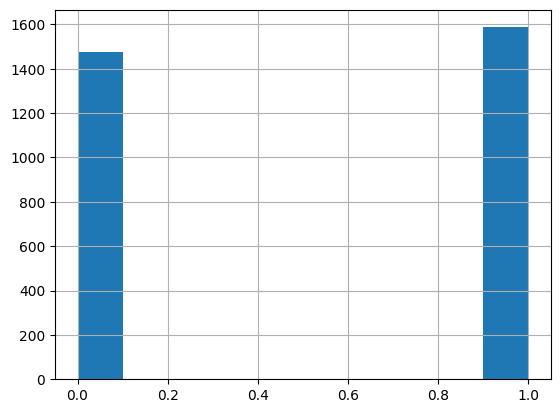

[I 2023-04-23 14:41:25,849] A new study created in memory with name: no-name-86a0e2d2-74d5-4e76-ba95-28be826de4fd


16/16 [==============================] - 1s 4ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 5ms/step
lstm: 0.500990099009901, one_acc: 0.500990099009901
16/16 [==============================] - 0s 3ms/step
lstm: 0.5069306930693069, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 4ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 4ms/step


[I 2023-04-23 14:41:50,173] Trial 0 finished with value: 0.0023762376237623783 and parameters: {'lstm_units': 11, 'n_units': 28, 'lr_rate': 0.05957022752983803}. Best is trial 0 with value: 0.0023762376237623783.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 4ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 4ms/step
lstm: 0.500990099009901, one_acc: 0.500990099009901
16/16 [==============================] - 0s 4ms/step
lstm: 0.49504950495049505, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 3ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 4ms/step


[I 2023-04-23 14:42:14,362] Trial 1 finished with value: 0.0 and parameters: {'lstm_units': 131, 'n_units': 24, 'lr_rate': 0.040878125236881335}. Best is trial 0 with value: 0.0023762376237623783.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 4ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 3ms/step
lstm: 0.500990099009901, one_acc: 0.500990099009901
16/16 [==============================] - 0s 4ms/step
lstm: 0.504950495049505, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 3ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 4ms/step


[I 2023-04-23 14:42:35,616] Trial 2 finished with value: 0.001980198019801982 and parameters: {'lstm_units': 120, 'n_units': 112, 'lr_rate': 0.05649110541398233}. Best is trial 0 with value: 0.0023762376237623783.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 3ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 3ms/step
lstm: 0.500990099009901, one_acc: 0.500990099009901
16/16 [==============================] - 0s 3ms/step
lstm: 0.49504950495049505, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 3ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 4ms/step


[I 2023-04-23 14:42:56,197] Trial 3 finished with value: 0.0 and parameters: {'lstm_units': 149, 'n_units': 76, 'lr_rate': 0.02674096051517645}. Best is trial 0 with value: 0.0023762376237623783.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 6ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 3ms/step
lstm: 0.5267326732673268, one_acc: 0.500990099009901
16/16 [==============================] - 0s 3ms/step
lstm: 0.4910891089108911, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 3ms/step
lstm: 0.5405940594059406, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 5ms/step


[I 2023-04-23 14:43:19,594] Trial 4 finished with value: 0.003960396039603964 and parameters: {'lstm_units': 48, 'n_units': 179, 'lr_rate': 0.0017182412758420561}. Best is trial 4 with value: 0.003960396039603964.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 4ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 4ms/step
lstm: 0.5168316831683168, one_acc: 0.500990099009901
16/16 [==============================] - 0s 3ms/step
lstm: 0.499009900990099, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 3ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 3ms/step


[I 2023-04-23 14:43:41,102] Trial 5 finished with value: 0.003960396039603964 and parameters: {'lstm_units': 23, 'n_units': 134, 'lr_rate': 0.020571422235101753}. Best is trial 4 with value: 0.003960396039603964.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 3ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 3ms/step
lstm: 0.499009900990099, one_acc: 0.500990099009901
16/16 [==============================] - 0s 4ms/step
lstm: 0.504950495049505, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 4ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 3ms/step


[I 2023-04-23 14:44:05,279] Trial 6 finished with value: 0.0015841584158415856 and parameters: {'lstm_units': 144, 'n_units': 16, 'lr_rate': 0.07149409045411173}. Best is trial 4 with value: 0.003960396039603964.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 3ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 4ms/step
lstm: 0.500990099009901, one_acc: 0.500990099009901
16/16 [==============================] - 0s 3ms/step
lstm: 0.504950495049505, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 3ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 3ms/step


[I 2023-04-23 14:44:28,879] Trial 7 finished with value: 0.001980198019801982 and parameters: {'lstm_units': 94, 'n_units': 140, 'lr_rate': 0.08033501089141681}. Best is trial 4 with value: 0.003960396039603964.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 5ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 3ms/step
lstm: 0.5148514851485149, one_acc: 0.500990099009901
16/16 [==============================] - 0s 3ms/step
lstm: 0.48514851485148514, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 3ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 3ms/step


[I 2023-04-23 14:44:47,345] Trial 8 finished with value: 0.0015841584158415856 and parameters: {'lstm_units': 109, 'n_units': 29, 'lr_rate': 0.0030515909851266455}. Best is trial 4 with value: 0.003960396039603964.


lstm: 0.5326732673267327, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 3ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 3ms/step
lstm: 0.499009900990099, one_acc: 0.500990099009901
16/16 [==============================] - 0s 5ms/step
lstm: 0.504950495049505, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 4ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 4ms/step


[I 2023-04-23 14:45:12,228] Trial 9 finished with value: 0.0015841584158415856 and parameters: {'lstm_units': 103, 'n_units': 110, 'lr_rate': 0.08425614348909347}. Best is trial 4 with value: 0.003960396039603964.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 4ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 3ms/step
lstm: 0.504950495049505, one_acc: 0.500990099009901
16/16 [==============================] - 0s 3ms/step
lstm: 0.500990099009901, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 5ms/step
lstm: 0.5386138613861386, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 3ms/step


[I 2023-04-23 14:45:32,858] Trial 10 finished with value: 0.0011881188118811892 and parameters: {'lstm_units': 197, 'n_units': 199, 'lr_rate': 0.002346030379787073}. Best is trial 4 with value: 0.003960396039603964.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 4ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 4ms/step
lstm: 0.500990099009901, one_acc: 0.500990099009901
16/16 [==============================] - 0s 3ms/step
lstm: 0.504950495049505, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 3ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 4ms/step


[I 2023-04-23 14:45:52,957] Trial 11 finished with value: 0.001980198019801982 and parameters: {'lstm_units': 23, 'n_units': 179, 'lr_rate': 0.020535396736137804}. Best is trial 4 with value: 0.003960396039603964.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 4ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 4ms/step
lstm: 0.500990099009901, one_acc: 0.500990099009901
16/16 [==============================] - 0s 3ms/step
lstm: 0.504950495049505, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 3ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 5ms/step


[I 2023-04-23 14:46:18,997] Trial 12 finished with value: 0.001980198019801982 and parameters: {'lstm_units': 52, 'n_units': 161, 'lr_rate': 0.09895877689190029}. Best is trial 4 with value: 0.003960396039603964.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 3ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 3ms/step
lstm: 0.500990099009901, one_acc: 0.500990099009901
16/16 [==============================] - 0s 3ms/step
lstm: 0.504950495049505, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 5ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 4ms/step


[I 2023-04-23 14:46:35,619] Trial 13 finished with value: 0.001980198019801982 and parameters: {'lstm_units': 55, 'n_units': 137, 'lr_rate': 0.017325933086704447}. Best is trial 4 with value: 0.003960396039603964.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 4ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 4ms/step
lstm: 0.504950495049505, one_acc: 0.500990099009901
16/16 [==============================] - 0s 3ms/step
lstm: 0.5069306930693069, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 3ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 4ms/step


[I 2023-04-23 14:46:55,718] Trial 14 finished with value: 0.003168316831683171 and parameters: {'lstm_units': 50, 'n_units': 76, 'lr_rate': 0.03779773303885983}. Best is trial 4 with value: 0.003960396039603964.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 3ms/step
lstm: 0.5405940594059406, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 4ms/step
lstm: 0.5227722772277228, one_acc: 0.500990099009901
16/16 [==============================] - 0s 3ms/step
lstm: 0.49504950495049505, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 3ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 3ms/step


[I 2023-04-23 14:47:15,708] Trial 15 finished with value: 0.0027722772277227747 and parameters: {'lstm_units': 75, 'n_units': 158, 'lr_rate': 0.00878182823760277}. Best is trial 4 with value: 0.003960396039603964.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 3ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 5ms/step
lstm: 0.5227722772277228, one_acc: 0.500990099009901
16/16 [==============================] - 0s 3ms/step
lstm: 0.504950495049505, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 3ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 3ms/step


[I 2023-04-23 14:47:34,111] Trial 16 finished with value: 0.006336633663366342 and parameters: {'lstm_units': 24, 'n_units': 197, 'lr_rate': 0.012769352130059912}. Best is trial 16 with value: 0.006336633663366342.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 4ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 3ms/step
lstm: 0.5386138613861386, one_acc: 0.500990099009901
16/16 [==============================] - 0s 3ms/step
lstm: 0.4910891089108911, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 5ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 5ms/step


[I 2023-04-23 14:47:52,777] Trial 17 finished with value: 0.006732673267326739 and parameters: {'lstm_units': 37, 'n_units': 196, 'lr_rate': 0.01072132827979378}. Best is trial 17 with value: 0.006732673267326739.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 4ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 5ms/step
lstm: 0.500990099009901, one_acc: 0.500990099009901
16/16 [==============================] - 0s 3ms/step
lstm: 0.504950495049505, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 3ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 5ms/step


[I 2023-04-23 14:48:15,507] Trial 18 finished with value: 0.001980198019801982 and parameters: {'lstm_units': 74, 'n_units': 198, 'lr_rate': 0.030805942770133845}. Best is trial 17 with value: 0.006732673267326739.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
16/16 [==============================] - 1s 4ms/step
lstm: 0.5485148514851486, one_acc: 0.5485148514851486
16/16 [==============================] - 0s 3ms/step
lstm: 0.500990099009901, one_acc: 0.500990099009901
16/16 [==============================] - 0s 5ms/step
lstm: 0.4891089108910891, one_acc: 0.49504950495049505
16/16 [==============================] - 0s 3ms/step
lstm: 0.5425742574257426, one_acc: 0.5425742574257426
16/16 [==============================] - 0s 3ms/step


[I 2023-04-23 14:48:40,578] Trial 19 finished with value: -0.0011881188118811892 and parameters: {'lstm_units': 32, 'n_units': 170, 'lr_rate': 0.013936769073910768}. Best is trial 17 with value: 0.006732673267326739.


lstm: 0.5287128712871287, one_acc: 0.5287128712871287
Best parameters: {'lstm_units': 37, 'n_units': 196, 'lr_rate': 0.01072132827979378}
AAPL


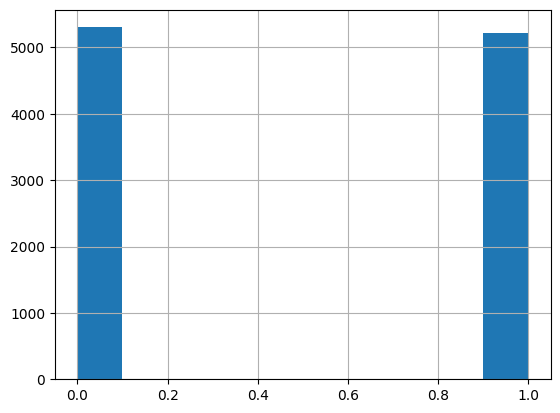

[I 2023-04-23 14:48:40,886] A new study created in memory with name: no-name-b150d1e7-9ad4-4a00-87fe-5a5dd0bce7fb


55/55 [==============================] - 1s 3ms/step
lstm: 0.5386376645678306, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 3ms/step
lstm: 0.5289066971951918, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 3ms/step
lstm: 0.4962793360045793, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.5088723526044648, one_acc: 0.529479107040641
55/55 [==============================] - 0s 3ms/step


[I 2023-04-23 14:49:29,545] Trial 0 finished with value: 0.018088151116199234 and parameters: {'lstm_units': 130, 'n_units': 58, 'lr_rate': 0.0015094337966489245}. Best is trial 0 with value: 0.018088151116199234.


lstm: 0.5323411562678878, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 3ms/step
lstm: 0.5414997137950772, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 3ms/step
lstm: 0.5317687464224384, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 3ms/step
lstm: 0.4922724670864339, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.5254722381224957, one_acc: 0.529479107040641
55/55 [==============================] - 0s 3ms/step


[I 2023-04-23 14:50:18,829] Trial 1 finished with value: 0.021064682312535776 and parameters: {'lstm_units': 81, 'n_units': 117, 'lr_rate': 0.004546239765112956}. Best is trial 1 with value: 0.021064682312535776.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 3ms/step
lstm: 0.5346307956496852, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 3ms/step
lstm: 0.5266170578133944, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 3ms/step
lstm: 0.5174585002862049, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 4ms/step
lstm: 0.529479107040641, one_acc: 0.529479107040641
55/55 [==============================] - 0s 3ms/step


[I 2023-04-23 14:51:14,380] Trial 2 finished with value: 0.024499141385231838 and parameters: {'lstm_units': 167, 'n_units': 157, 'lr_rate': 0.05714372450342379}. Best is trial 2 with value: 0.024499141385231838.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 3ms/step
lstm: 0.5346307956496852, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 3ms/step
lstm: 0.5266170578133944, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 3ms/step
lstm: 0.5174585002862049, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.529479107040641, one_acc: 0.529479107040641
55/55 [==============================] - 0s 3ms/step


[I 2023-04-23 14:52:11,079] Trial 3 finished with value: 0.024499141385231838 and parameters: {'lstm_units': 158, 'n_units': 114, 'lr_rate': 0.08827547303433741}. Best is trial 2 with value: 0.024499141385231838.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 4ms/step
lstm: 0.5346307956496852, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 4ms/step
lstm: 0.5300515168860904, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 3ms/step
lstm: 0.5214653692043503, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 4ms/step
lstm: 0.529479107040641, one_acc: 0.529479107040641
55/55 [==============================] - 0s 3ms/step


[I 2023-04-23 14:53:13,871] Trial 4 finished with value: 0.02598740698340012 and parameters: {'lstm_units': 116, 'n_units': 141, 'lr_rate': 0.006911078381737413}. Best is trial 4 with value: 0.02598740698340012.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 3ms/step
lstm: 0.5340583858042358, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 3ms/step
lstm: 0.5317687464224384, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 3ms/step
lstm: 0.5174585002862049, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.529479107040641, one_acc: 0.529479107040641
55/55 [==============================] - 0s 5ms/step


[I 2023-04-23 14:54:01,601] Trial 5 finished with value: 0.025414997137950767 and parameters: {'lstm_units': 23, 'n_units': 57, 'lr_rate': 0.027483856657187646}. Best is trial 4 with value: 0.02598740698340012.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 3ms/step
lstm: 0.5346307956496852, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 3ms/step
lstm: 0.5266170578133944, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 3ms/step
lstm: 0.5174585002862049, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.529479107040641, one_acc: 0.529479107040641
55/55 [==============================] - 0s 3ms/step


[I 2023-04-23 14:54:37,902] Trial 6 finished with value: 0.024499141385231838 and parameters: {'lstm_units': 92, 'n_units': 109, 'lr_rate': 0.03469665395828274}. Best is trial 4 with value: 0.02598740698340012.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 5ms/step
lstm: 0.5346307956496852, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 3ms/step
lstm: 0.5266170578133944, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 3ms/step
lstm: 0.5174585002862049, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.529479107040641, one_acc: 0.529479107040641
55/55 [==============================] - 0s 4ms/step


[I 2023-04-23 14:55:41,911] Trial 7 finished with value: 0.024499141385231838 and parameters: {'lstm_units': 146, 'n_units': 65, 'lr_rate': 0.06155220757777773}. Best is trial 4 with value: 0.02598740698340012.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 4ms/step
lstm: 0.5352032054951346, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 3ms/step
lstm: 0.5266170578133944, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 3ms/step
lstm: 0.5174585002862049, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.529479107040641, one_acc: 0.529479107040641
55/55 [==============================] - 0s 3ms/step


[I 2023-04-23 14:56:29,273] Trial 8 finished with value: 0.024613623354321712 and parameters: {'lstm_units': 38, 'n_units': 110, 'lr_rate': 0.03596841686520753}. Best is trial 4 with value: 0.02598740698340012.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 3ms/step
lstm: 0.5346307956496852, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 4ms/step
lstm: 0.5266170578133944, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 3ms/step
lstm: 0.5174585002862049, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.529479107040641, one_acc: 0.529479107040641
55/55 [==============================] - 0s 3ms/step


[I 2023-04-23 14:57:20,111] Trial 9 finished with value: 0.024499141385231838 and parameters: {'lstm_units': 65, 'n_units': 125, 'lr_rate': 0.06787376352976658}. Best is trial 4 with value: 0.02598740698340012.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 4ms/step
lstm: 0.5346307956496852, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 4ms/step
lstm: 0.5266170578133944, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 4ms/step
lstm: 0.48254149971379506, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.529479107040641, one_acc: 0.529479107040641
55/55 [==============================] - 0s 3ms/step
lstm: 0.5289066971951918, one_acc: 0.5289066971951918


[I 2023-04-23 14:58:31,268] Trial 10 finished with value: 0.017515741270749875 and parameters: {'lstm_units': 189, 'n_units': 189, 'lr_rate': 0.017040853095657612}. Best is trial 4 with value: 0.02598740698340012.


55/55 [==============================] - 1s 4ms/step
lstm: 0.5346307956496852, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 3ms/step
lstm: 0.5334859759587864, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 3ms/step
lstm: 0.5123068116771609, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.529479107040641, one_acc: 0.529479107040641
55/55 [==============================] - 0s 5ms/step


[I 2023-04-23 14:59:18,626] Trial 11 finished with value: 0.02484258729250144 and parameters: {'lstm_units': 22, 'n_units': 13, 'lr_rate': 0.02271072564643621}. Best is trial 4 with value: 0.02598740698340012.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 3ms/step
lstm: 0.5346307956496852, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 3ms/step
lstm: 0.5266170578133944, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 4ms/step
lstm: 0.4997137950772753, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.5248998282770464, one_acc: 0.529479107040641
55/55 [==============================] - 0s 4ms/step


[I 2023-04-23 15:00:20,352] Trial 12 finished with value: 0.020034344590726994 and parameters: {'lstm_units': 116, 'n_units': 62, 'lr_rate': 0.021242691782468095}. Best is trial 4 with value: 0.02598740698340012.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 3ms/step
lstm: 0.5346307956496852, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 3ms/step
lstm: 0.5266170578133944, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 3ms/step
lstm: 0.5174585002862049, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.529479107040641, one_acc: 0.529479107040641
55/55 [==============================] - 0s 3ms/step


[I 2023-04-23 15:01:03,914] Trial 13 finished with value: 0.024499141385231838 and parameters: {'lstm_units': 54, 'n_units': 154, 'lr_rate': 0.04173428309386122}. Best is trial 4 with value: 0.02598740698340012.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 3ms/step
lstm: 0.5346307956496852, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 4ms/step
lstm: 0.5340583858042358, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 3ms/step
lstm: 0.48254149971379506, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.4911276473955352, one_acc: 0.529479107040641
55/55 [==============================] - 0s 5ms/step


[I 2023-04-23 15:02:05,268] Trial 14 finished with value: 0.011333714939896988 and parameters: {'lstm_units': 108, 'n_units': 25, 'lr_rate': 0.012944438886693284}. Best is trial 4 with value: 0.02598740698340012.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 3ms/step
lstm: 0.5346307956496852, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 5ms/step
lstm: 0.5266170578133944, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 4ms/step
lstm: 0.5123068116771609, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.529479107040641, one_acc: 0.529479107040641
55/55 [==============================] - 0s 3ms/step


[I 2023-04-23 15:03:13,000] Trial 15 finished with value: 0.02346880366342303 and parameters: {'lstm_units': 11, 'n_units': 85, 'lr_rate': 0.02787084497334089}. Best is trial 4 with value: 0.02598740698340012.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 3ms/step
lstm: 0.5397824842587292, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 3ms/step
lstm: 0.5266170578133944, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 3ms/step
lstm: 0.4968517458500286, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 5ms/step
lstm: 0.5329135661133372, one_acc: 0.529479107040641
55/55 [==============================] - 0s 4ms/step


[I 2023-04-23 15:04:05,282] Trial 16 finished with value: 0.022095020034344614 and parameters: {'lstm_units': 83, 'n_units': 149, 'lr_rate': 0.010809978223227221}. Best is trial 4 with value: 0.02598740698340012.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 3ms/step
lstm: 0.5346307956496852, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 4ms/step
lstm: 0.5266170578133944, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 4ms/step
lstm: 0.5174585002862049, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.529479107040641, one_acc: 0.529479107040641
55/55 [==============================] - 0s 3ms/step


[I 2023-04-23 15:04:56,009] Trial 17 finished with value: 0.024499141385231838 and parameters: {'lstm_units': 134, 'n_units': 43, 'lr_rate': 0.04606716148555518}. Best is trial 4 with value: 0.02598740698340012.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 1s 3ms/step
lstm: 0.5346307956496852, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 3ms/step
lstm: 0.5266170578133944, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 4ms/step
lstm: 0.48254149971379506, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 3ms/step
lstm: 0.529479107040641, one_acc: 0.529479107040641
55/55 [==============================] - 0s 3ms/step


[I 2023-04-23 15:05:46,522] Trial 18 finished with value: 0.017515741270749875 and parameters: {'lstm_units': 50, 'n_units': 83, 'lr_rate': 0.028187460008430202}. Best is trial 4 with value: 0.02598740698340012.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
55/55 [==============================] - 2s 3ms/step
lstm: 0.5346307956496852, one_acc: 0.4653692043503148
55/55 [==============================] - 0s 5ms/step
lstm: 0.5266170578133944, one_acc: 0.4733829421866056
55/55 [==============================] - 0s 3ms/step
lstm: 0.5174585002862049, one_acc: 0.5174585002862049
55/55 [==============================] - 0s 4ms/step
lstm: 0.529479107040641, one_acc: 0.529479107040641
55/55 [==============================] - 0s 3ms/step


[I 2023-04-23 15:06:32,384] Trial 19 finished with value: 0.024499141385231838 and parameters: {'lstm_units': 194, 'n_units': 194, 'lr_rate': 0.010733437798167437}. Best is trial 4 with value: 0.02598740698340012.


lstm: 0.5289066971951918, one_acc: 0.5289066971951918
Best parameters: {'lstm_units': 116, 'n_units': 141, 'lr_rate': 0.006911078381737413}
MSFT


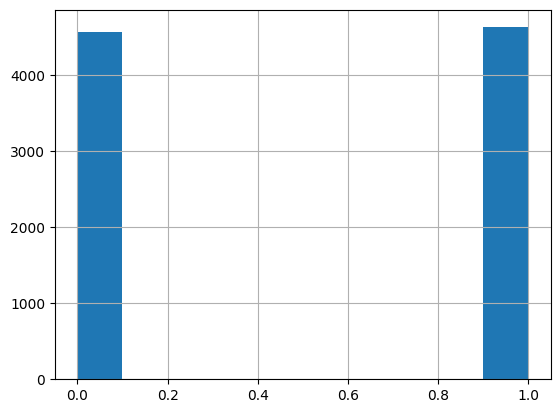

[I 2023-04-23 15:06:32,616] A new study created in memory with name: no-name-8e71ec93-c51f-4c8d-b1bd-4a1486181b20


48/48 [==============================] - 1s 3ms/step
lstm: 0.5, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 3ms/step
lstm: 0.5111402359108781, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 3ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 3ms/step
lstm: 0.5, one_acc: 0.5
48/48 [==============================] - 0s 3ms/step
lstm: 0.536697247706422, one_acc: 0.536697247706422


[I 2023-04-23 15:07:19,644] Trial 0 finished with value: 0.007339449541284393 and parameters: {'lstm_units': 102, 'n_units': 76, 'lr_rate': 0.024225428635836675}. Best is trial 0 with value: 0.007339449541284393.


48/48 [==============================] - 1s 3ms/step
lstm: 0.5013106159895151, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 3ms/step
lstm: 0.5111402359108781, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 4ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 4ms/step
lstm: 0.5, one_acc: 0.5
48/48 [==============================] - 0s 3ms/step


[I 2023-04-23 15:08:31,107] Trial 1 finished with value: 0.007601572739187412 and parameters: {'lstm_units': 154, 'n_units': 186, 'lr_rate': 0.024519502915951872}. Best is trial 1 with value: 0.007601572739187412.


lstm: 0.536697247706422, one_acc: 0.536697247706422
48/48 [==============================] - 1s 4ms/step
lstm: 0.5013106159895151, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 5ms/step
lstm: 0.5111402359108781, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 3ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 3ms/step
lstm: 0.5, one_acc: 0.5
48/48 [==============================] - 0s 5ms/step


[I 2023-04-23 15:09:16,611] Trial 2 finished with value: 0.007601572739187412 and parameters: {'lstm_units': 164, 'n_units': 185, 'lr_rate': 0.047368825228650595}. Best is trial 1 with value: 0.007601572739187412.


lstm: 0.536697247706422, one_acc: 0.536697247706422
48/48 [==============================] - 1s 5ms/step
lstm: 0.5013106159895151, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 3ms/step
lstm: 0.5111402359108781, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 3ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 4ms/step
lstm: 0.5, one_acc: 0.5
48/48 [==============================] - 0s 5ms/step


[I 2023-04-23 15:10:10,195] Trial 3 finished with value: 0.007601572739187412 and parameters: {'lstm_units': 109, 'n_units': 145, 'lr_rate': 0.06417728719834663}. Best is trial 1 with value: 0.007601572739187412.


lstm: 0.536697247706422, one_acc: 0.536697247706422
48/48 [==============================] - 2s 4ms/step
lstm: 0.5058977719528178, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 3ms/step
lstm: 0.5117955439056356, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 4ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 4ms/step
lstm: 0.4986893840104849, one_acc: 0.5
48/48 [==============================] - 0s 3ms/step


[I 2023-04-23 15:10:58,082] Trial 4 finished with value: 0.008387942332896447 and parameters: {'lstm_units': 131, 'n_units': 188, 'lr_rate': 0.010273511075518566}. Best is trial 4 with value: 0.008387942332896447.


lstm: 0.536697247706422, one_acc: 0.536697247706422
48/48 [==============================] - 1s 3ms/step
lstm: 0.4986893840104849, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 3ms/step
lstm: 0.5111402359108781, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 3ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 4ms/step
lstm: 0.5, one_acc: 0.5
48/48 [==============================] - 0s 3ms/step


[I 2023-04-23 15:11:41,797] Trial 5 finished with value: 0.007077326343381374 and parameters: {'lstm_units': 59, 'n_units': 36, 'lr_rate': 0.06184993685937659}. Best is trial 4 with value: 0.008387942332896447.


lstm: 0.536697247706422, one_acc: 0.536697247706422
48/48 [==============================] - 1s 4ms/step
lstm: 0.5013106159895151, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 5ms/step
lstm: 0.5111402359108781, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 4ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 3ms/step
lstm: 0.5, one_acc: 0.5
48/48 [==============================] - 0s 4ms/step


[I 2023-04-23 15:12:30,520] Trial 6 finished with value: 0.007601572739187412 and parameters: {'lstm_units': 174, 'n_units': 18, 'lr_rate': 0.029691029337509084}. Best is trial 4 with value: 0.008387942332896447.


lstm: 0.536697247706422, one_acc: 0.536697247706422
48/48 [==============================] - 1s 3ms/step
lstm: 0.5013106159895151, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 4ms/step
lstm: 0.5111402359108781, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 3ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 4ms/step
lstm: 0.5, one_acc: 0.5
48/48 [==============================] - 0s 5ms/step


[I 2023-04-23 15:13:42,666] Trial 7 finished with value: 0.007601572739187412 and parameters: {'lstm_units': 152, 'n_units': 76, 'lr_rate': 0.09349867809036996}. Best is trial 4 with value: 0.008387942332896447.


lstm: 0.536697247706422, one_acc: 0.536697247706422
48/48 [==============================] - 1s 4ms/step
lstm: 0.5013106159895151, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 3ms/step
lstm: 0.5111402359108781, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 5ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 5ms/step
lstm: 0.5, one_acc: 0.5
48/48 [==============================] - 0s 3ms/step


[I 2023-04-23 15:14:43,640] Trial 8 finished with value: 0.007601572739187412 and parameters: {'lstm_units': 167, 'n_units': 200, 'lr_rate': 0.07712080017750526}. Best is trial 4 with value: 0.008387942332896447.


lstm: 0.536697247706422, one_acc: 0.536697247706422
48/48 [==============================] - 1s 3ms/step
lstm: 0.5013106159895151, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 3ms/step
lstm: 0.5111402359108781, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 3ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 3ms/step
lstm: 0.5, one_acc: 0.5
48/48 [==============================] - 0s 3ms/step
lstm: 0.536697247706422, one_acc: 0.536697247706422


[I 2023-04-23 15:15:33,053] Trial 9 finished with value: 0.007601572739187412 and parameters: {'lstm_units': 40, 'n_units': 115, 'lr_rate': 0.03153219064685218}. Best is trial 4 with value: 0.008387942332896447.


48/48 [==============================] - 1s 3ms/step
lstm: 0.5111402359108781, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 3ms/step
lstm: 0.5150720838794234, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 4ms/step
lstm: 0.4967234600262123, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 5ms/step
lstm: 0.5275229357798165, one_acc: 0.5
48/48 [==============================] - 0s 4ms/step


[I 2023-04-23 15:16:21,838] Trial 10 finished with value: 0.013630406290956732 and parameters: {'lstm_units': 102, 'n_units': 147, 'lr_rate': 0.004139027275271973}. Best is trial 10 with value: 0.013630406290956732.


lstm: 0.536697247706422, one_acc: 0.536697247706422
48/48 [==============================] - 1s 4ms/step
lstm: 0.5006553079947575, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 4ms/step
lstm: 0.5124508519003932, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 3ms/step
lstm: 0.47575360419397117, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 3ms/step
lstm: 0.5235910878112713, one_acc: 0.5
48/48 [==============================] - 0s 3ms/step


[I 2023-04-23 15:17:03,734] Trial 11 finished with value: -0.01022280471821757 and parameters: {'lstm_units': 107, 'n_units': 152, 'lr_rate': 0.001327306880642462}. Best is trial 10 with value: 0.013630406290956732.


lstm: 0.45543905635648757, one_acc: 0.536697247706422
48/48 [==============================] - 1s 4ms/step
lstm: 0.5216251638269986, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 4ms/step
lstm: 0.5111402359108781, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 5ms/step
lstm: 0.5058977719528178, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 4ms/step
lstm: 0.5222804718217562, one_acc: 0.5
48/48 [==============================] - 0s 3ms/step


[I 2023-04-23 15:17:53,351] Trial 12 finished with value: -0.0005242463958060606 and parameters: {'lstm_units': 79, 'n_units': 151, 'lr_rate': 0.0024406643196799097}. Best is trial 10 with value: 0.013630406290956732.


lstm: 0.45543905635648757, one_acc: 0.536697247706422
48/48 [==============================] - 1s 4ms/step
lstm: 0.5157273918741808, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 4ms/step
lstm: 0.5065530799475754, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 4ms/step
lstm: 0.5039318479685452, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 3ms/step
lstm: 0.5032765399737876, one_acc: 0.5
48/48 [==============================] - 0s 3ms/step


[I 2023-04-23 15:18:54,301] Trial 13 finished with value: 0.00930537352555697 and parameters: {'lstm_units': 11, 'n_units': 116, 'lr_rate': 0.0058413056781627185}. Best is trial 10 with value: 0.013630406290956732.


lstm: 0.5360419397116645, one_acc: 0.536697247706422
48/48 [==============================] - 1s 3ms/step
lstm: 0.5078636959370905, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 4ms/step
lstm: 0.5111402359108781, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 3ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 3ms/step
lstm: 0.49934469200524245, one_acc: 0.5
48/48 [==============================] - 0s 3ms/step


[I 2023-04-23 15:19:33,174] Trial 14 finished with value: 0.008781127129750977 and parameters: {'lstm_units': 10, 'n_units': 109, 'lr_rate': 0.013880459331030319}. Best is trial 10 with value: 0.013630406290956732.


lstm: 0.536697247706422, one_acc: 0.536697247706422
48/48 [==============================] - 1s 3ms/step
lstm: 0.5013106159895151, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 4ms/step
lstm: 0.5111402359108781, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 4ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 4ms/step
lstm: 0.5, one_acc: 0.5
48/48 [==============================] - 0s 4ms/step


[I 2023-04-23 15:20:47,989] Trial 15 finished with value: 0.007601572739187412 and parameters: {'lstm_units': 196, 'n_units': 129, 'lr_rate': 0.01533769380687}. Best is trial 10 with value: 0.013630406290956732.


lstm: 0.536697247706422, one_acc: 0.536697247706422
48/48 [==============================] - 1s 3ms/step
lstm: 0.5013106159895151, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 3ms/step
lstm: 0.5111402359108781, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 4ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 3ms/step
lstm: 0.5, one_acc: 0.5
48/48 [==============================] - 0s 3ms/step


[I 2023-04-23 15:21:42,329] Trial 16 finished with value: 0.007601572739187412 and parameters: {'lstm_units': 10, 'n_units': 79, 'lr_rate': 0.03879131480551476}. Best is trial 10 with value: 0.013630406290956732.


lstm: 0.536697247706422, one_acc: 0.536697247706422
48/48 [==============================] - 1s 4ms/step
lstm: 0.5131061598951507, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 3ms/step
lstm: 0.5111402359108781, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 3ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 3ms/step
lstm: 0.5, one_acc: 0.5
48/48 [==============================] - 0s 3ms/step


[I 2023-04-23 15:22:27,797] Trial 17 finished with value: 0.00996068152031454 and parameters: {'lstm_units': 44, 'n_units': 91, 'lr_rate': 0.019176387612036088}. Best is trial 10 with value: 0.013630406290956732.


lstm: 0.536697247706422, one_acc: 0.536697247706422
48/48 [==============================] - 1s 5ms/step
lstm: 0.5013106159895151, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 4ms/step
lstm: 0.509829619921363, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 3ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 3ms/step
lstm: 0.5, one_acc: 0.5
48/48 [==============================] - 0s 3ms/step


[I 2023-04-23 15:23:14,642] Trial 18 finished with value: 0.007339449541284393 and parameters: {'lstm_units': 42, 'n_units': 51, 'lr_rate': 0.02094840467277858}. Best is trial 10 with value: 0.013630406290956732.


lstm: 0.536697247706422, one_acc: 0.536697247706422
48/48 [==============================] - 1s 4ms/step
lstm: 0.4986893840104849, one_acc: 0.5013106159895151
48/48 [==============================] - 0s 3ms/step
lstm: 0.5111402359108781, one_acc: 0.4888597640891219
48/48 [==============================] - 0s 4ms/step
lstm: 0.5078636959370905, one_acc: 0.4921363040629096
48/48 [==============================] - 0s 4ms/step
lstm: 0.5072083879423329, one_acc: 0.5
48/48 [==============================] - 0s 3ms/step


[I 2023-04-23 15:23:54,062] Trial 19 finished with value: 0.008519003931847957 and parameters: {'lstm_units': 79, 'n_units': 95, 'lr_rate': 0.014828988103609973}. Best is trial 10 with value: 0.013630406290956732.


lstm: 0.536697247706422, one_acc: 0.536697247706422
Best parameters: {'lstm_units': 102, 'n_units': 147, 'lr_rate': 0.004139027275271973}
SPY


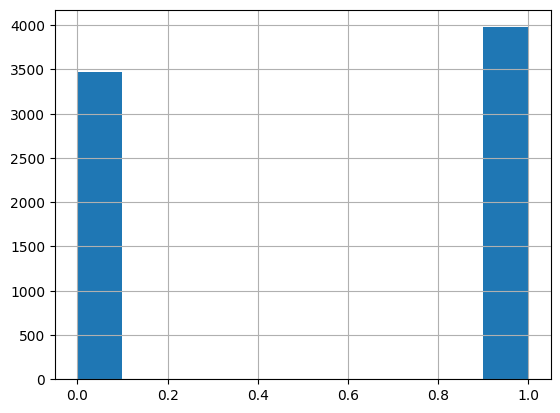

[I 2023-04-23 15:23:55,118] A new study created in memory with name: no-name-cb2388aa-c34f-4bb7-bf8d-1fe0da1cd625


39/39 [==============================] - 1s 4ms/step
lstm: 0.5137540453074434, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 3ms/step
lstm: 0.5412621359223301, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 3ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 4ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 4ms/step


[I 2023-04-23 15:25:01,806] Trial 0 finished with value: 0.0029126213592232998 and parameters: {'lstm_units': 82, 'n_units': 67, 'lr_rate': 0.016736049658162545}. Best is trial 0 with value: 0.0029126213592232998.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 3ms/step
lstm: 0.5097087378640777, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 5ms/step
lstm: 0.5501618122977346, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 3ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 4ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 4ms/step


[I 2023-04-23 15:25:47,373] Trial 1 finished with value: 0.003883495145631066 and parameters: {'lstm_units': 133, 'n_units': 77, 'lr_rate': 0.04993546099574589}. Best is trial 1 with value: 0.003883495145631066.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 4ms/step
lstm: 0.5097087378640777, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 3ms/step
lstm: 0.5501618122977346, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 5ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 3ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 3ms/step


[I 2023-04-23 15:26:22,077] Trial 2 finished with value: 0.003883495145631066 and parameters: {'lstm_units': 120, 'n_units': 108, 'lr_rate': 0.01822829644250735}. Best is trial 1 with value: 0.003883495145631066.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 5ms/step
lstm: 0.5097087378640777, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 3ms/step
lstm: 0.5501618122977346, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 3ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 4ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 3ms/step


[I 2023-04-23 15:27:09,235] Trial 3 finished with value: 0.003883495145631066 and parameters: {'lstm_units': 113, 'n_units': 149, 'lr_rate': 0.06848423866599947}. Best is trial 1 with value: 0.003883495145631066.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 5ms/step
lstm: 0.5097087378640777, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 4ms/step
lstm: 0.5501618122977346, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 3ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 4ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 3ms/step


[I 2023-04-23 15:27:58,375] Trial 4 finished with value: 0.003883495145631066 and parameters: {'lstm_units': 169, 'n_units': 125, 'lr_rate': 0.04768224467757316}. Best is trial 1 with value: 0.003883495145631066.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 4ms/step
lstm: 0.49029126213592233, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 4ms/step
lstm: 0.5501618122977346, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 4ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 3ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 3ms/step


[I 2023-04-23 15:28:44,189] Trial 5 finished with value: 0.0 and parameters: {'lstm_units': 157, 'n_units': 87, 'lr_rate': 0.014074486517219993}. Best is trial 1 with value: 0.003883495145631066.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 5ms/step
lstm: 0.5097087378640777, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 4ms/step
lstm: 0.5501618122977346, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 4ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 3ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 3ms/step


[I 2023-04-23 15:29:23,565] Trial 6 finished with value: 0.003883495145631066 and parameters: {'lstm_units': 109, 'n_units': 54, 'lr_rate': 0.08838501368491153}. Best is trial 1 with value: 0.003883495145631066.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 5ms/step
lstm: 0.5097087378640777, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 5ms/step
lstm: 0.5501618122977346, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 3ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 4ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 5ms/step


[I 2023-04-23 15:30:09,815] Trial 7 finished with value: 0.003883495145631066 and parameters: {'lstm_units': 21, 'n_units': 184, 'lr_rate': 0.06738798970280412}. Best is trial 1 with value: 0.003883495145631066.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 4ms/step
lstm: 0.5097087378640777, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 3ms/step
lstm: 0.5501618122977346, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 5ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 4ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 3ms/step


[I 2023-04-23 15:31:04,083] Trial 8 finished with value: 0.003883495145631066 and parameters: {'lstm_units': 185, 'n_units': 63, 'lr_rate': 0.05416216263643192}. Best is trial 1 with value: 0.003883495145631066.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 5ms/step
lstm: 0.5097087378640777, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 3ms/step
lstm: 0.5501618122977346, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 4ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 5ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 4ms/step


[I 2023-04-23 15:31:38,247] Trial 9 finished with value: 0.003883495145631066 and parameters: {'lstm_units': 106, 'n_units': 180, 'lr_rate': 0.0787940867704573}. Best is trial 1 with value: 0.003883495145631066.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 4ms/step
lstm: 0.5105177993527508, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 3ms/step
lstm: 0.5493527508090615, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 4ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 3ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 5ms/step


[I 2023-04-23 15:32:20,085] Trial 10 finished with value: 0.003883495145631066 and parameters: {'lstm_units': 60, 'n_units': 21, 'lr_rate': 0.03872215704280141}. Best is trial 1 with value: 0.003883495145631066.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 4ms/step
lstm: 0.5097087378640777, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 4ms/step
lstm: 0.5501618122977346, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 3ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 4ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 5ms/step
lstm: 0.5453074433656958, one_acc: 0.5453074433656958


[I 2023-04-23 15:32:58,778] Trial 11 finished with value: 0.003883495145631066 and parameters: {'lstm_units': 140, 'n_units': 110, 'lr_rate': 0.022580972334976572}. Best is trial 1 with value: 0.003883495145631066.


39/39 [==============================] - 1s 5ms/step
lstm: 0.511326860841424, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 4ms/step
lstm: 0.5598705501618123, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 4ms/step
lstm: 0.5444983818770227, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 5ms/step
lstm: 0.5533980582524272, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 3ms/step


[I 2023-04-23 15:33:44,717] Trial 12 finished with value: 0.007766990291262132 and parameters: {'lstm_units': 138, 'n_units': 141, 'lr_rate': 0.006205098866417458}. Best is trial 12 with value: 0.007766990291262132.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 4ms/step
lstm: 0.5307443365695793, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 4ms/step
lstm: 0.5420711974110033, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 4ms/step
lstm: 0.5412621359223301, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 3ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 4ms/step


[I 2023-04-23 15:34:27,497] Trial 13 finished with value: 0.0063106796116504825 and parameters: {'lstm_units': 198, 'n_units': 144, 'lr_rate': 0.0075437502877433605}. Best is trial 12 with value: 0.007766990291262132.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 4ms/step
lstm: 0.5226537216828478, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 3ms/step
lstm: 0.540453074433657, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 3ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 3ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 5ms/step


[I 2023-04-23 15:35:05,504] Trial 14 finished with value: 0.00453074433656957 and parameters: {'lstm_units': 190, 'n_units': 154, 'lr_rate': 0.006870968375368192}. Best is trial 12 with value: 0.007766990291262132.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 5ms/step
lstm: 0.4894822006472492, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 3ms/step
lstm: 0.5501618122977346, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 4ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 3ms/step
lstm: 0.5396440129449838, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 3ms/step


[I 2023-04-23 15:35:44,899] Trial 15 finished with value: -0.002265372168284807 and parameters: {'lstm_units': 196, 'n_units': 142, 'lr_rate': 0.0013697555493367682}. Best is trial 12 with value: 0.007766990291262132.


lstm: 0.5428802588996764, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 4ms/step
lstm: 0.5097087378640777, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 3ms/step
lstm: 0.5501618122977346, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 3ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 4ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 4ms/step


[I 2023-04-23 15:36:20,139] Trial 16 finished with value: 0.003883495145631066 and parameters: {'lstm_units': 153, 'n_units': 200, 'lr_rate': 0.027984320915735317}. Best is trial 12 with value: 0.007766990291262132.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 3ms/step
lstm: 0.4894822006472492, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 5ms/step
lstm: 0.5542071197411004, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 3ms/step
lstm: 0.5388349514563107, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 3ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 5ms/step
lstm: 0.5453074433656958, one_acc: 0.5453074433656958


[I 2023-04-23 15:37:01,614] Trial 17 finished with value: -1.1102230246251566e-17 and parameters: {'lstm_units': 84, 'n_units': 129, 'lr_rate': 0.0024585127608797277}. Best is trial 12 with value: 0.007766990291262132.


39/39 [==============================] - 1s 4ms/step
lstm: 0.5097087378640777, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 4ms/step
lstm: 0.5501618122977346, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 4ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 3ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 6ms/step


[I 2023-04-23 15:37:37,839] Trial 18 finished with value: 0.003883495145631066 and parameters: {'lstm_units': 176, 'n_units': 169, 'lr_rate': 0.03302240447466362}. Best is trial 12 with value: 0.007766990291262132.


lstm: 0.5453074433656958, one_acc: 0.5453074433656958
39/39 [==============================] - 1s 4ms/step
lstm: 0.5097087378640777, one_acc: 0.49029126213592233
39/39 [==============================] - 0s 5ms/step
lstm: 0.5501618122977346, one_acc: 0.5501618122977346
39/39 [==============================] - 0s 3ms/step
lstm: 0.5420711974110033, one_acc: 0.5420711974110033
39/39 [==============================] - 0s 3ms/step
lstm: 0.5477346278317152, one_acc: 0.5477346278317152
39/39 [==============================] - 0s 3ms/step
lstm: 0.5453074433656958, one_acc: 0.5453074433656958


[I 2023-04-23 15:38:08,427] Trial 19 finished with value: 0.003883495145631066 and parameters: {'lstm_units': 39, 'n_units': 95, 'lr_rate': 0.010681169787184117}. Best is trial 12 with value: 0.007766990291262132.


Best parameters: {'lstm_units': 138, 'n_units': 141, 'lr_rate': 0.006205098866417458}


In [ ]:
# hyperparameter tuning

best_param_dict = {}
for i in range(len(stock_list)):
    s = stock_list[i]
    print(stock_list[i])
    # load the dataset
    df = stock_df_list[i]

    # use training data
    # standardised test data as the last 107 entries
    df = df[:-107]

    feat_df = df[feature_list]
    label_df = df['labels_shifted']

    label_df.hist()
    plt.show()

    feature_arr = get_feature_arr(feat_df, window_size)
    label_arr = get_label_arr(label_df, window_size)

    # Set up the Optuna study and optimize the hyperparameters
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)

    # Get the best hyperparameters
    best_params = study.best_params
    print(f'Best parameters: {best_params}')
    best_param_dict[s] = best_params

In [ ]:
best_param_dict

{'GME': {'lstm_units': 93, 'n_units': 72, 'lr_rate': 0.0192346399735825},
 'AMC': {'lstm_units': 197, 'n_units': 167, 'lr_rate': 0.0023706555261508513},
 'BBBY': {'lstm_units': 151, 'n_units': 11, 'lr_rate': 0.014980321414993447},
 'TSLA': {'lstm_units': 37, 'n_units': 196, 'lr_rate': 0.01072132827979378},
 'AAPL': {'lstm_units': 116, 'n_units': 141, 'lr_rate': 0.006911078381737413},
 'MSFT': {'lstm_units': 102, 'n_units': 147, 'lr_rate': 0.004139027275271973},
 'SPY': {'lstm_units': 138, 'n_units': 141, 'lr_rate': 0.006205098866417458}}

In [5]:
# saved from previous run
best_param_dict = {'GME': {'lstm_units': 93, 'n_units': 72, 'lr_rate': 0.0192346399735825},
 'AMC': {'lstm_units': 197, 'n_units': 167, 'lr_rate': 0.0023706555261508513},
 'BBBY': {'lstm_units': 151, 'n_units': 11, 'lr_rate': 0.014980321414993447},
 'TSLA': {'lstm_units': 37, 'n_units': 196, 'lr_rate': 0.01072132827979378},
 'AAPL': {'lstm_units': 116, 'n_units': 141, 'lr_rate': 0.006911078381737413},
 'MSFT': {'lstm_units': 102, 'n_units': 147, 'lr_rate': 0.004139027275271973},
 'SPY': {'lstm_units': 138, 'n_units': 141, 'lr_rate': 0.006205098866417458}}

GME
Epoch 1/100
41/41 [==============================] - 11s 147ms/step - loss: 0.8683 - accuracy: 0.5010 - val_loss: 0.6937 - val_accuracy: 0.4860
Epoch 2/100
41/41 [==============================] - 5s 114ms/step - loss: 0.6959 - accuracy: 0.4988 - val_loss: 0.6945 - val_accuracy: 0.4860
Epoch 3/100
41/41 [==============================] - 6s 149ms/step - loss: 0.6941 - accuracy: 0.4975 - val_loss: 0.6932 - val_accuracy: 0.4953
Epoch 4/100
41/41 [==============================] - 5s 113ms/step - loss: 0.6952 - accuracy: 0.5004 - val_loss: 0.6993 - val_accuracy: 0.4860
Epoch 5/100
41/41 [==============================] - 6s 149ms/step - loss: 0.6939 - accuracy: 0.4899 - val_loss: 0.6940 - val_accuracy: 0.4860
Epoch 6/100
41/41 [==============================] - 7s 162ms/step - loss: 0.6940 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.4673
Epoch 7/100
41/41 [==============================] - 10s 243ms/step - loss: 0.6934 - accuracy: 0.5041 - val_loss: 0.6947 - val_accuracy: 

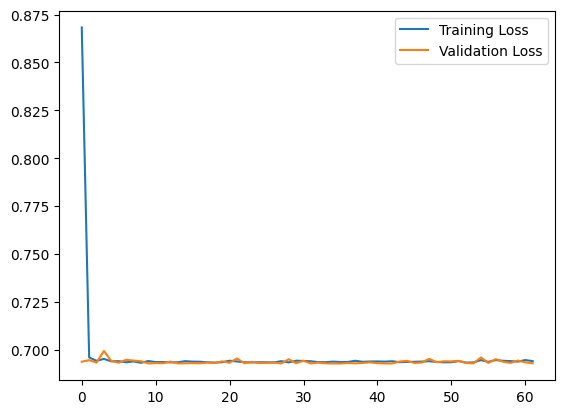

4/4 [==============================] - 1s 13ms/step
lstm: 0.514018691588785
AMC
Epoch 1/100
17/17 [==============================] - 11s 384ms/step - loss: 0.7261 - accuracy: 0.4942 - val_loss: 0.6905 - val_accuracy: 0.5888
Epoch 2/100
17/17 [==============================] - 6s 383ms/step - loss: 0.6923 - accuracy: 0.5234 - val_loss: 0.6930 - val_accuracy: 0.5794
Epoch 3/100
17/17 [==============================] - 5s 305ms/step - loss: 0.6957 - accuracy: 0.5151 - val_loss: 0.6900 - val_accuracy: 0.5888
Epoch 4/100
17/17 [==============================] - 6s 349ms/step - loss: 0.6919 - accuracy: 0.5234 - val_loss: 0.6836 - val_accuracy: 0.5888
Epoch 5/100
17/17 [==============================] - 6s 317ms/step - loss: 0.6918 - accuracy: 0.5304 - val_loss: 0.6832 - val_accuracy: 0.5888
Epoch 6/100
17/17 [==============================] - 5s 303ms/step - loss: 0.6913 - accuracy: 0.5294 - val_loss: 0.6967 - val_accuracy: 0.3832
Epoch 7/100
17/17 [==============================] - 6s 382ms

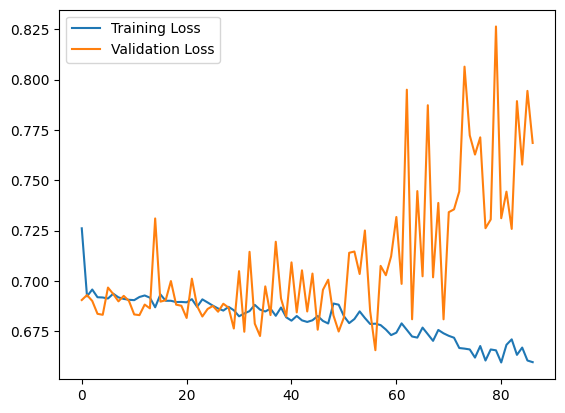

4/4 [==============================] - 1s 70ms/step
lstm: 0.6355140186915887
BBBY
Epoch 1/100
60/60 [==============================] - 19s 245ms/step - loss: 0.7835 - accuracy: 0.4965 - val_loss: 0.7147 - val_accuracy: 0.3458
Epoch 2/100
60/60 [==============================] - 14s 230ms/step - loss: 0.6941 - accuracy: 0.5097 - val_loss: 0.6898 - val_accuracy: 0.6542
Epoch 3/100
60/60 [==============================] - 14s 230ms/step - loss: 0.6945 - accuracy: 0.5027 - val_loss: 0.6820 - val_accuracy: 0.6542
Epoch 4/100
60/60 [==============================] - 14s 231ms/step - loss: 0.6931 - accuracy: 0.5082 - val_loss: 0.6902 - val_accuracy: 0.6542
Epoch 5/100
60/60 [==============================] - 14s 237ms/step - loss: 0.6935 - accuracy: 0.5056 - val_loss: 0.6795 - val_accuracy: 0.6542
Epoch 6/100
60/60 [==============================] - 14s 238ms/step - loss: 0.6939 - accuracy: 0.5048 - val_loss: 0.6794 - val_accuracy: 0.6542
Epoch 7/100
60/60 [==============================] - 1

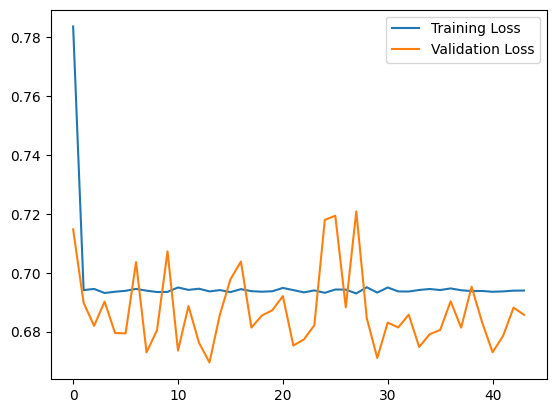

4/4 [==============================] - 1s 33ms/step
lstm: 0.6542056074766355
TSLA
Epoch 1/100
24/24 [==============================] - 6s 85ms/step - loss: 0.7441 - accuracy: 0.4904 - val_loss: 0.6910 - val_accuracy: 0.5140
Epoch 2/100
24/24 [==============================] - 1s 45ms/step - loss: 0.6949 - accuracy: 0.5129 - val_loss: 0.6945 - val_accuracy: 0.5234
Epoch 3/100
24/24 [==============================] - 2s 64ms/step - loss: 0.6950 - accuracy: 0.5099 - val_loss: 0.6930 - val_accuracy: 0.5234
Epoch 4/100
24/24 [==============================] - 2s 79ms/step - loss: 0.6936 - accuracy: 0.5102 - val_loss: 0.6928 - val_accuracy: 0.4953
Epoch 5/100
24/24 [==============================] - 1s 47ms/step - loss: 0.6925 - accuracy: 0.5208 - val_loss: 0.6924 - val_accuracy: 0.5234
Epoch 6/100
24/24 [==============================] - 1s 45ms/step - loss: 0.6934 - accuracy: 0.5099 - val_loss: 0.6920 - val_accuracy: 0.5234
Epoch 7/100
24/24 [==============================] - 1s 47ms/step 

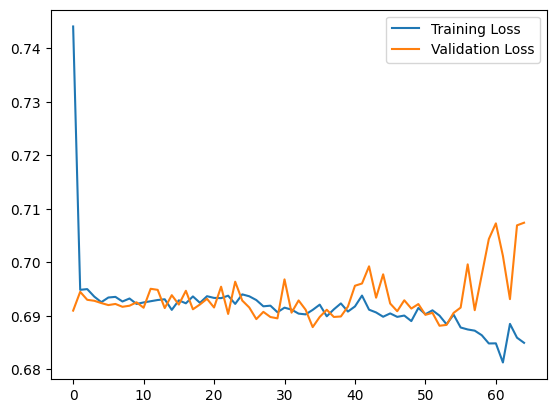

4/4 [==============================] - 1s 9ms/step
lstm: 0.514018691588785
AAPL
Epoch 1/100
82/82 [==============================] - 20s 178ms/step - loss: 0.7116 - accuracy: 0.5140 - val_loss: 0.6919 - val_accuracy: 0.5327
Epoch 2/100
82/82 [==============================] - 14s 167ms/step - loss: 0.6947 - accuracy: 0.5049 - val_loss: 0.6918 - val_accuracy: 0.5327
Epoch 3/100
82/82 [==============================] - 14s 166ms/step - loss: 0.6931 - accuracy: 0.5064 - val_loss: 0.6904 - val_accuracy: 0.5327
Epoch 4/100
82/82 [==============================] - 14s 167ms/step - loss: 0.6933 - accuracy: 0.5115 - val_loss: 0.6918 - val_accuracy: 0.5327
Epoch 5/100
82/82 [==============================] - 14s 167ms/step - loss: 0.6927 - accuracy: 0.5136 - val_loss: 0.6963 - val_accuracy: 0.4673
Epoch 6/100
82/82 [==============================] - 14s 167ms/step - loss: 0.6929 - accuracy: 0.5119 - val_loss: 0.6921 - val_accuracy: 0.5794
Epoch 7/100
82/82 [==============================] - 14s

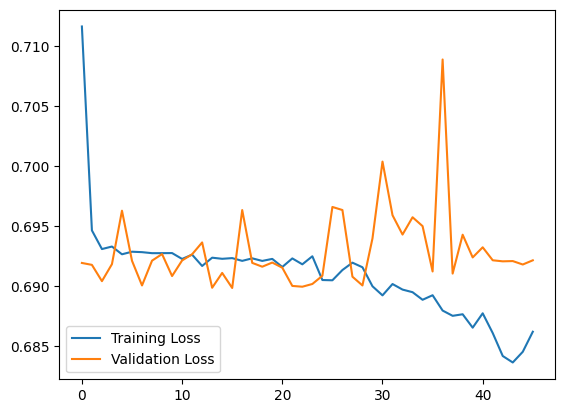

4/4 [==============================] - 1s 26ms/step
lstm: 0.5327102803738317
MSFT
Epoch 1/100
72/72 [==============================] - 15s 163ms/step - loss: 0.6987 - accuracy: 0.5089 - val_loss: 0.6954 - val_accuracy: 0.4953
Epoch 2/100
72/72 [==============================] - 11s 151ms/step - loss: 0.6938 - accuracy: 0.5087 - val_loss: 0.6933 - val_accuracy: 0.5047
Epoch 3/100
72/72 [==============================] - 11s 152ms/step - loss: 0.6943 - accuracy: 0.4967 - val_loss: 0.6958 - val_accuracy: 0.4953
Epoch 4/100
72/72 [==============================] - 9s 131ms/step - loss: 0.6936 - accuracy: 0.4995 - val_loss: 0.6939 - val_accuracy: 0.4953
Epoch 5/100
72/72 [==============================] - 11s 152ms/step - loss: 0.6935 - accuracy: 0.4986 - val_loss: 0.6938 - val_accuracy: 0.4953
Epoch 6/100
72/72 [==============================] - 11s 152ms/step - loss: 0.6936 - accuracy: 0.5020 - val_loss: 0.6933 - val_accuracy: 0.4953
Epoch 7/100
72/72 [==============================] - 11

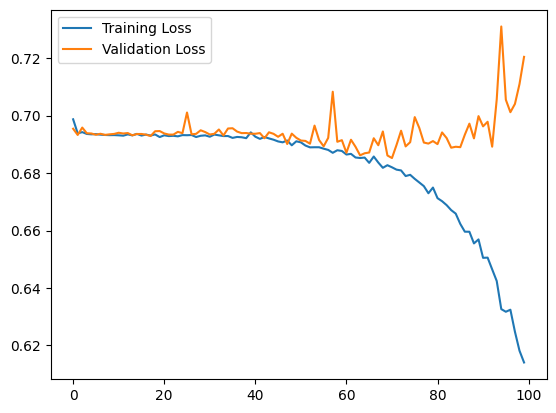

4/4 [==============================] - 1s 16ms/step
lstm: 0.6074766355140186
SPY
Epoch 1/100
58/58 [==============================] - 18s 232ms/step - loss: 0.7256 - accuracy: 0.5104 - val_loss: 0.7128 - val_accuracy: 0.4673
Epoch 2/100
58/58 [==============================] - 12s 202ms/step - loss: 0.6924 - accuracy: 0.5291 - val_loss: 0.7226 - val_accuracy: 0.4673
Epoch 3/100
58/58 [==============================] - 12s 209ms/step - loss: 0.6917 - accuracy: 0.5318 - val_loss: 0.7014 - val_accuracy: 0.4673
Epoch 4/100
58/58 [==============================] - 12s 210ms/step - loss: 0.6911 - accuracy: 0.5309 - val_loss: 0.7007 - val_accuracy: 0.4673
Epoch 5/100
58/58 [==============================] - 13s 215ms/step - loss: 0.6915 - accuracy: 0.5319 - val_loss: 0.6997 - val_accuracy: 0.4673
Epoch 6/100
58/58 [==============================] - 13s 219ms/step - loss: 0.6904 - accuracy: 0.5372 - val_loss: 0.6999 - val_accuracy: 0.4673
Epoch 7/100
58/58 [==============================] - 13

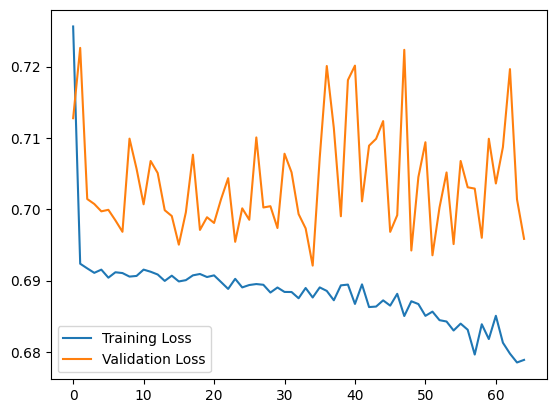

4/4 [==============================] - 2s 31ms/step
lstm: 0.5233644859813084
nan


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [6]:
# train model
acc_arr = []

# Train the model with early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

for i in range(len(stock_list)):
    s = stock_list[i]
    print(s)

    # use best values for hyperparameters
    lstm_units, n_units, lr_rate = best_param_dict[s]['lstm_units'], best_param_dict[s]['n_units'], best_param_dict[s]['lr_rate']

    # create model
    model = keras.Sequential()
    model.add(layers.LSTM(lstm_units, return_sequences=True, input_shape=(window_size, num_features)))
    model.add(layers.LSTM(lstm_units, return_sequences=False))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(n_units))
    model.add(layers.Dense(2, activation='softmax'))

    # Compile the model with the given learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    df = stock_df_list[i]

    feat_df = df[feature_list]
    label_df = df['labels_shifted']

    X = get_feature_arr(feat_df, window_size)
    y = get_label_arr(label_df, window_size)

    X_train, X_test = X[:-107], X[-107:]
    y_train, y_test = y[:-107], y[-107:]
    
    # Train and evaluate the model on this fold
    history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

    # plot training loss against validation loss
    # note that we are relying on the early callback to terminate training at the right time
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    # save weights
    model.save_weights(s+'_weights.h5')

    # predict for test data
    y_pred = model.predict(X_test)

    print(f'lstm: {calc_accuracy(y_test, y_pred)}')

    pred_df = df[-107:][['date', 'labels_shifted', 'close']]
    pred_df.set_index('date')
    pred_df['pred_label'] = np.array([np.argmax(i) for i in y_pred])

    pred_df.to_csv(s+'_pred.csv')

print(np.mean(acc_arr))

GME
0.514018691588785
AMC
0.6355140186915887
BBBY
0.6542056074766355
TSLA
0.514018691588785
AAPL
0.5327102803738317
MSFT
0.6074766355140186
SPY
0.5233644859813084


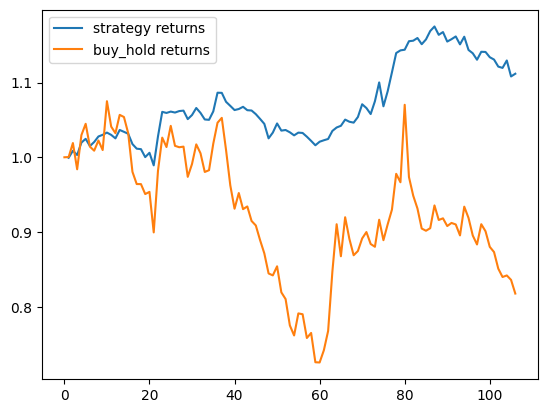

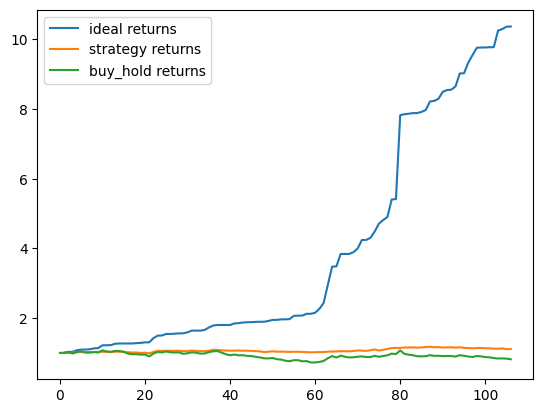

0.568758344459279


In [7]:


acc_arr = []

ir = np.zeros(107)
ar = np.zeros(107)
br = np.zeros(107)

for s in stock_list:
    print(s)
    df = pd.read_csv(s+'_pred.csv')
    
    df['returns'] = df['close'].pct_change()
    acc = accuracy_score(df['labels_shifted'].values, df['pred_label'].values)
    print(acc)
    acc_arr.append(acc)

    df['ideal_returns'] = df['returns'] * df['labels_shifted'].shift(1)
    df['actual_returns'] = df['returns'] * df['pred_label'].shift(1)

    df['ideal_returns'] = df['ideal_returns'].values + 1
    df['actual_returns'] = df['actual_returns'].values + 1

    df['bh_returns'] = df['close'].values / df['close'].values[0]
    
    ir = ir + df['ideal_returns'].cumprod()
    ar = ar + df['actual_returns'].cumprod()
    br = br + df['bh_returns']



# plt.plot(ir / 7, label='ideal returns')
plt.plot(ar / 7, label='strategy returns')
plt.plot(br / 7, label='buy_hold returns')
plt.legend()
plt.show()

plt.plot(ir / 7, label='ideal returns')
plt.plot(ar / 7, label='strategy returns')
plt.plot(br / 7, label='buy_hold returns')
plt.legend()
plt.show()
    

print(np.mean(acc_arr))

